In [1]:
!pip install ta

import ta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Random Forest

In [2]:
np.random.seed(1111)

df = pd.read_csv('Database.csv', index_col=0)
df.index = pd.to_datetime(df.index, format="%m/%d/%Y %H:%M:%S")
df.head()

,Open,High,Low,Close,Volume,Return,Output
Date,,,,,,,
2010-01-04 16:56:00,11.89,12.24,11.87,12.16,3601600,-0.06,0
2010-01-05 16:56:00,12.23,12.27,11.93,12.10,4246200,-0.10,0
2010-01-06 16:56:00,12.06,12.15,11.93,12.00,3736000,-0.03,0
2010-01-07 16:56:00,11.94,12.02,11.85,11.97,2201800,-0.02,0
2010-01-08 16:56:00,12.03,12.03,11.84,11.95,2390300,0.01,1


## Feature Engineering

### Date Feature

In [40]:
dataDates = df.index

df["year"] =  dataDates.year
df["month"] = dataDates.month
df["day"] = dataDates.day
df["weekday"] = dataDates.weekday
df["quarter"] =  dataDates.quarter
df.head()

,Open,High,Low,Close,Volume,Return,Output,year,month,day,...,Close_Lag_22,Log_Volume_22,Trend_22,Close_Ratio_66,Close_Rolling_Mean_66,Close_Rolling_Std_66,Close_Expanding_Mean_66,Close_Lag_66,Log_Volume_66,Trend_66
Date,,,,,,,,,,,,,,,,,,,,,
2010-04-12 16:56:00,11.92,12.03,11.80,11.82,4714700,-0.11,0,2010,4,12,...,11.35,14.987303,11.0,1.036732,11.401212,0.345015,0.354719,12.16,15.146534,31.0
2011-04-01 16:56:00,11.82,11.88,11.71,11.71,3072300,0.04,1,2011,4,1,...,11.41,14.998424,10.0,1.027616,11.395303,0.336087,0.353905,12.10,15.141824,31.0
2011-04-02 16:56:00,11.71,11.81,11.61,11.75,3678900,-0.16,0,2011,4,2,...,11.29,15.009908,11.0,1.031469,11.391515,0.330530,0.353574,12.00,15.141594,32.0
2011-04-03 16:56:00,11.75,11.78,11.55,11.59,4276900,-0.24,0,2011,4,3,...,11.26,15.033479,11.0,1.017938,11.385758,0.323534,0.351578,11.97,15.149908,32.0
2011-04-04 16:56:00,11.55,11.55,11.26,11.35,5313600,-0.10,0,2011,4,4,...,11.36,15.102493,10.0,0.997656,11.376667,0.315772,0.349169,11.95,15.161503,32.0


### Time Series Feature



In [41]:
open = df.Open
high = df.High
low = df.Low
close = df.Close
volume = df.Volume

In [42]:
df['Close_Lag_1'] = close.shift(1)
#df['Log_Volume'] = np.log(df.Volume)
df['Volume_diff'] = df.Volume.diff()
df['Volume_Percentage_Change'] = df.Volume.pct_change()

horizons = [2, 3, 4, 5, 10, 22, 66]
#new_predictors = []

for horizon in horizons:
    rolling_averages = df.rolling(horizon).mean()
    rolling_std = df.rolling(horizon).std()
    expanding_averages = df.expanding(horizon).mean()
    expanding_std = df.expanding(horizon).std()

    close_ratio_column = f"Close_Ratio_{horizon}"
    df[close_ratio_column] = df["Close"] / rolling_averages["Close"]

    # Rolling Avg
    close_rolling_mean_column = f"Close_Rolling_Mean_{horizon}"
    df[close_rolling_mean_column] = rolling_averages["Close"]

    # Rolling Standard Deviation
    close_rolling_std_column = f"Close_Rolling_Std_{horizon}"
    df[close_rolling_std_column] = rolling_std["Close"]

    # Expanding Avg
    close_expanding_mean_column = f"Close_Expanding_Mean_{horizon}"
    df[close_expanding_mean_column] = expanding_averages["Close"]

    # Expanding Standard Deviation
    close_expanding_std_column = f"Close_Expanding_Mean_{horizon}"
    df[close_expanding_std_column] = expanding_std["Close"]

    # Lag Feature
    close_lag_column = f"Close_Lag_{horizon}"
    df[close_lag_column] = close.shift(horizon)

    # Log Volume
    log_volume_column = f"Log_Volume_{horizon}"
    df[log_volume_column] = df.Volume.rolling(horizon).mean().apply(np.log)

    trend_column = f"Trend_{horizon}"
    df[trend_column] = df.shift(1).rolling(horizon).sum()["Output"]

    #new_predictors+= [close_ratio_column, close_rolling_mean_column, close_rolling_std_column,  close_expanding_mean_column, close_lag_column, trend_column]

In [43]:
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna()
df.head()

,Open,High,Low,Close,Volume,Return,Output,year,month,day,...,Close_Lag_22,Log_Volume_22,Trend_22,Close_Ratio_66,Close_Rolling_Mean_66,Close_Rolling_Std_66,Close_Expanding_Mean_66,Close_Lag_66,Log_Volume_66,Trend_66
Date,,,,,,,,,,,,,,,,,,,,,
2011-07-11 16:56:00,11.95,12.04,11.84,12.03,2894500,-0.04,0,2011,7,11,...,10.89,15.008850,13.0,1.099010,10.946212,0.468828,0.477352,11.82,15.170777,30.0
2012-07-02 16:56:00,12.05,12.14,11.95,11.99,2281300,0.04,1,2012,7,2,...,10.77,15.039807,13.0,1.094932,10.950455,0.477040,0.489987,11.71,15.167682,30.0
2012-07-03 16:56:00,12.09,12.16,11.99,12.03,3689600,0.54,1,2012,7,3,...,10.89,15.043462,13.0,1.098159,10.954697,0.485432,0.502699,11.75,15.167724,30.0
2012-07-04 16:56:00,12.12,12.64,12.05,12.57,10474100,-0.01,0,2012,7,4,...,10.93,15.142453,13.0,1.145900,10.969545,0.518991,0.533591,11.59,15.191722,31.0
2012-07-05 16:56:00,12.53,12.69,12.43,12.56,4023500,0.03,1,2012,7,5,...,10.61,15.149961,13.0,1.143078,10.987879,0.552901,0.560705,11.35,15.186773,31.0


### Technical Indicator Feature

In [356]:
# Money Flow Multiplier: [(Close - Low) - (High - Close)] /(High - Low)
money_flow_mult = ((close - low) - (high - close)) /(high - low)
df['money_flow_mult'] = money_flow_mult

# Money Flow Volume: Money Flow Multiplier x Volume for the Period
money_flow_volume = money_flow_mult * volume
df['money_flow_volume'] = money_flow_volume

# ADL(ADI): Previous ADL + Current Period's Money Flow Volume
adi = money_flow_volume.cumsum()
df['adi'] = adi

# Chaikin Money Flow
cmf = money_flow_volume.rolling(20).sum() / volume.rolling(20).sum()
df['chaikin_money_flow'] = adi

# Simple Moving Average (SMA)
sma_5 = close.transform(lambda x: x.rolling(window = 5).mean())
df['sma_5'] = sma_5
sma_15 = close.transform(lambda x: x.rolling(window = 15).mean())
df['sma_15'] = sma_15

SMA_ratio = sma_15/sma_5
df['SMA_ratio'] = SMA_ratio

# Simple Moving Average Volume
sma_5_volume = volume.transform(lambda x: x.rolling(window = 5).mean())
df['sma_5_volume'] = sma_5_volume
sma_15_volume = close.transform(lambda x: x.rolling(window = 15).mean())
df['sma_15_volume'] = sma_15_volume

SMA_ratio_volume = sma_15_volume/sma_5_volume
df['SMA_ratio_volume'] = SMA_ratio_volume

# Exponential Moving Average (EMA)
df['EMA_5'] = ta.trend.ema_indicator(df['Close'], window=5)
df['EMA_14'] = ta.trend.ema_indicator(df['Close'], window=14)

# Moving Average Convergence Divergence (MACD)
df['MACD'] = ta.trend.macd_diff(df['Close'])

# Relative Strength Index (RSI)
df['RSI_5'] = ta.momentum.rsi(df['Close'], window=5)
df['RSI_14'] = ta.momentum.rsi(df['Close'], window=14)

# ATR
atr = ta.volatility.average_true_range(high,low,close,window=14)
df['atr'] = atr

# KCPI
kcpi = ta.volatility.keltner_channel_pband(high,low,close)
df['kcpi'] = kcpi

# DCPI
dcpi = ta.volatility.donchian_channel_pband(high,low,close)
df['dcpi'] = dcpi

# BBPI
bbpi = ta.volatility.bollinger_pband(close,window=20)
df['bbpi'] = bbpi

# EOM
eom = ta.volume.ease_of_movement(high,low,volume,1)
df['eom'] = eom

# Bollinger Bands
df['BB_High'] = ta.volatility.bollinger_hband(df['Close'])
df['BB_Low'] = ta.volatility.bollinger_lband(df['Close'])

# On-Balance Volume (OBV)
df['OBV'] = ta.volume.on_balance_volume(df['Close'], df['Volume'])

# Money Flow Index (MFI)
df['MFI'] = ta.volume.money_flow_index(df['High'], df['Low'], df['Close'], df['Volume'])



<ipython-input-356-4bd040d6edc2>:3: FutureWarning: reindexing with a non-unique Index is deprecated and will raise in a future version.
  df['money_flow_mult'] = money_flow_mult


ValueError: ignored

In [ ]:
########## Time Series Features ##########

#Open Lag
#df['open_lag_1'] = open.shift(1)
#df['open_lag_2'] = open.shift(2)
#df['open_lag_3'] = open.shift(3)
#df['open_lag_4'] = open.shift(4)
#df['open_lag_5'] = open.shift(5)
#df['open_lag_10'] = open.shift(10)
#df['open_lag_22'] = open.shift(22)

#Close Lag
#df['close_lag_1'] = close.shift(1)
#df['close_lag_2'] = close.shift(2)
#df['close_lag_3'] = close.shift(3)
#df['close_lag_4'] = close.shift(4)
#df['close_lag_5'] = close.shift(5)
#df['close_lag_10'] = close.shift(10)
#df['close_lag_22'] = close.shift(22)

# Window Feature
# Standard Deviation
#rolling_std_3 = close.rolling(3).std()
#df['rolling_std_3'] = rolling_std_3
#rolling_std_5 = close.rolling(5).std()
#df['rolling_std_5'] = rolling_std_5
#rolling_std_22 = close.rolling(22).std()
#df['rolling_std_22'] = rolling_std_22

# Mean
#rolling_mean_3 = close.rolling(3).mean()
#df['rolling_mean_3'] = rolling_mean_3
#rolling_mean_5 = close.rolling(5).mean()
#df['rolling_mean_5'] = rolling_mean_5
#rolling_mean_22 = close.rolling(22).mean()
#df['rolling_mean_22'] = rolling_mean_22

#Expantion Feature
#expanding_mean_3 = close.expanding(3).mean()
#df['expanding_mean_3'] = expanding_mean_3
#expanding_mean_5 = close.expanding(5).mean()
#df['expanding_mean_5'] = expanding_mean_5
#expanding_mean_22 = close.expanding(22).mean()
#df['expanding_mean_22'] = expanding_mean_22

In [ ]:
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna()
#df = df.interpolate(option='linear', axis=1)
#df = df.replace([np.nan, -np.inf, np.inf], 0)
df.head()

### Lag Features test



In [ ]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.signal import periodogram
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_pacf

simplefilter("ignore")

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)
%config InlineBackend.figure_format = 'retina'


def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax


def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math

    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)

    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')

    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig


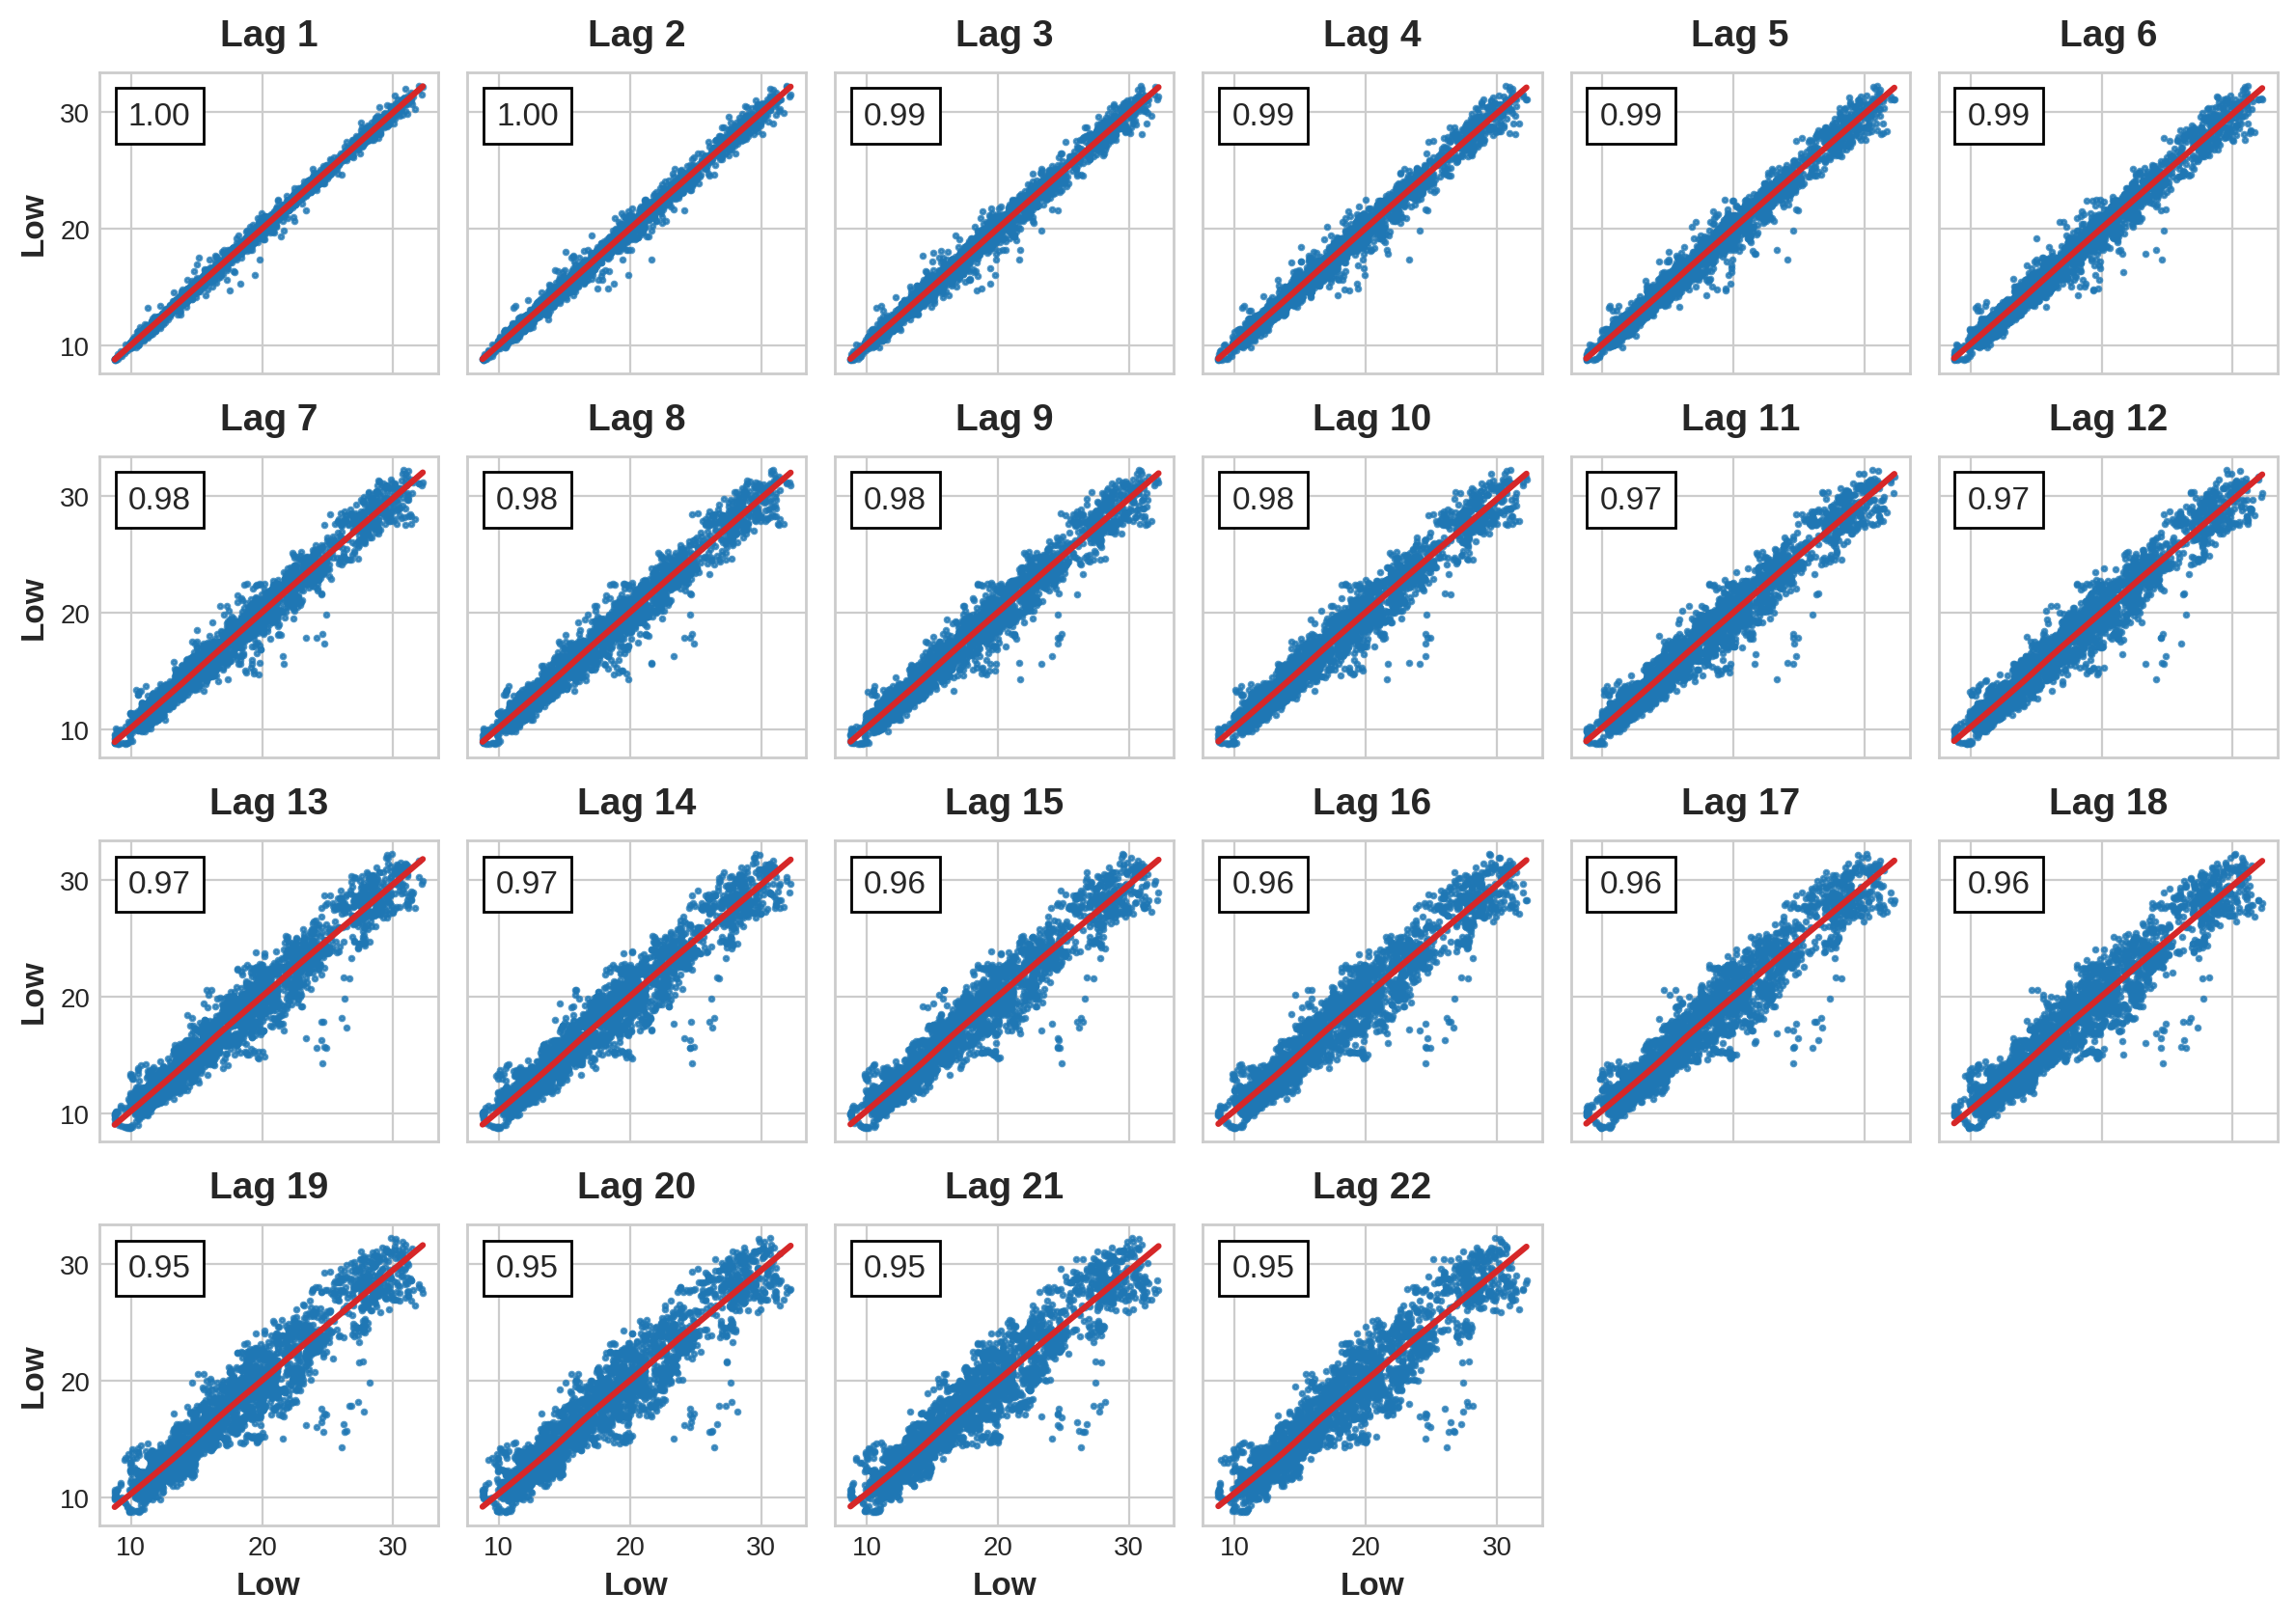

In [ ]:
_ = plot_lags(df.Low, lags=22, nrows=4)

## Split Dataset

In [44]:
def split_data(data):
  y_train = data.loc[data['year'] < 2022, 'Output']
  X_train = data.loc[data['year'] < 2022].drop(['Output', 'Return'], axis="columns")

  y_test = data.loc[data['year'] >= 2022, 'Output']
  X_test = data.loc[data['year'] >= 2022].drop(['Output', 'Return'], axis="columns")

  return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = split_data(df)

## Holdout

In [45]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier

# Feature Scaling
#sc = StandardScaler()
#X_train = sc.fit_transform(X_train)
#X_test = sc.transform(X_test)

# Remove low variance features
#selector = VarianceThreshold()
#X_train = selector.fit_transform(X_train)
#X_test = selector.transform(X_test)

# Fitting Random Forest Classification to the Training set
classifier = RandomForestClassifier(random_state=1111)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

## Evaluate

In [46]:
from sklearn.metrics import recall_score, precision_score, accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

def evaluate(y_test, y_pred):
  # Making the Confusion Matrix
  cm = confusion_matrix(y_test, y_pred)

  ConfusionMatrixDisplay(confusion_matrix=cm).plot();

  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  AUC = roc_auc_score(y_test, y_pred)

  print("Accuracy:", accuracy)
  print("Precision:", precision)
  print("Recall:", recall)
  print("AUC:", AUC)

Accuracy: 0.5032894736842105
Precision: 0.49340369393139843
Recall: 0.6296296296296297
AUC: 0.5061331427890914


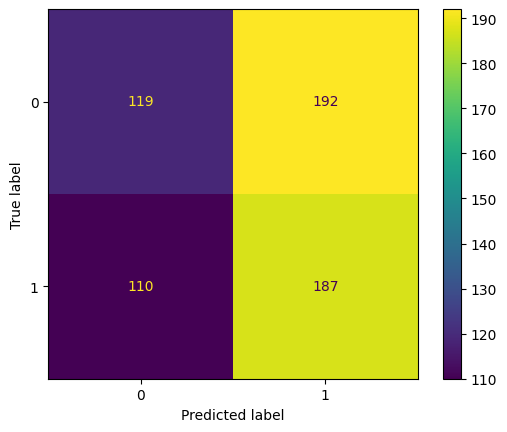

In [49]:
evaluate(y_test, y_pred)

## Time Series Split (22 days)

In [27]:
size = len(df.loc[df['year'] < 2022].index)
size_max = len(df)
n = -(size-size_max)/22

print(int(n))

27


In [28]:
from sklearn.model_selection import TimeSeriesSplit

def expanding_window(model, X_train, y_train, window_size):
  predictions = []
  actuals = []
  size = len(df.loc[df['year'] < 2022].index)
  size_max = len(df)
  tscv = TimeSeriesSplit(n_splits=(int(-(size-size_max)/window_size)), test_size = window_size)


  for i, (train_index, test_index) in enumerate(tscv.split(X_train)):
    print(f"N: {i}")
    print(f"  Train: index={train_index} - {train_index.size}")
    print(f"  Test:  index={test_index} - {test_index.size} ")

    X_train_window, X_test_window = X_train[train_index], X_train[test_index]
    y_train_window, y_test_window = y_train[train_index], y_train[test_index]

    model.fit(X_train_window, y_train_window)
    y_pred = model.predict(X_test_window)

    predictions.extend(y_pred)
    actuals.extend(y_test_window)

    #model.fit(X_train, y_train)
    #y_pred_test = model.predict(X_test)
    #predictions.extend(y_pred_test)
    #actuals.extend(y_test)
  return np.array(predictions), np.array(actuals)

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

def walk_forward_validation(model, X_train, y_train, X_test, y_test, window_size):
    predictions = []
    actuals = []
    size = len(df.loc[df['year'] < 2022].index)
    size_max =  len(df)

    #tscv = TimeSeriesSplit(n_splits=len(X_train) - window_size, test_size = window_size)
    tscv = TimeSeriesSplit(n_splits=122, test_size = window_size)


    #for i, (train_index, test_index) in enumerate(tscv.split(X_train)):
    indices = np.arange(len(X_train))
    test_starts = range(size, size_max, window_size)

    print(f"{size} {size_max}")
    for test_start in test_starts:
        train_index = indices[:test_start]
        test_index = indices[test_start : test_start + window_size]
        X_train_window, X_test_window = X_train[:test_start], X_train[test_start : test_start + window_size]
        y_train_window, y_test_window = y_train[:test_start], y_train[test_start : test_start + window_size]
        print(f"Fold: {test_start}")
        print(f"  Train: index={train_index} - {train_index.size}")
        print(f"  Test:  index={X_train[test_start : test_start + window_size].index} - {X_train[test_start : test_start + window_size].index.size} ")

        #model.fit(X_train_window, y_train_window)
        #y_pred = model.predict(X_test_window)

        #predictions.extend(y_pred)
        #actuals.extend(y_test_window)

    #model.fit(X_train, y_train)
    #y_pred_test = model.predict(X_test)
    #predictions.extend(y_pred_test)
    #actuals.extend(y_test)
    return np.array(predictions), np.array(actuals)


In [10]:
y_train = df['Output']
X_train = df.drop(['Output', 'Return'], axis="columns")

In [29]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Fitting Random Forest Classification to the Training set
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(random_state=4)
y_pred, y_test = expanding_window(classifier, X_train, y_train, window_size=22)

N: 0
  Train: index=[   0    1    2 ... 2662 2663 2664] - 2665
  Test:  index=[2665 2666 2667 2668 2669 2670 2671 2672 2673 2674 2675 2676 2677 2678
 2679 2680 2681 2682 2683 2684 2685 2686] - 22 
N: 1
  Train: index=[   0    1    2 ... 2684 2685 2686] - 2687
  Test:  index=[2687 2688 2689 2690 2691 2692 2693 2694 2695 2696 2697 2698 2699 2700
 2701 2702 2703 2704 2705 2706 2707 2708] - 22 
N: 2
  Train: index=[   0    1    2 ... 2706 2707 2708] - 2709
  Test:  index=[2709 2710 2711 2712 2713 2714 2715 2716 2717 2718 2719 2720 2721 2722
 2723 2724 2725 2726 2727 2728 2729 2730] - 22 
N: 3
  Train: index=[   0    1    2 ... 2728 2729 2730] - 2731
  Test:  index=[2731 2732 2733 2734 2735 2736 2737 2738 2739 2740 2741 2742 2743 2744
 2745 2746 2747 2748 2749 2750 2751 2752] - 22 
N: 4
  Train: index=[   0    1    2 ... 2750 2751 2752] - 2753
  Test:  index=[2753 2754 2755 2756 2757 2758 2759 2760 2761 2762 2763 2764 2765 2766
 2767 2768 2769 2770 2771 2772 2773 2774] - 22 
N: 5
  Train: i

Accuracy: 0.49188311688311687
Precision: 0.5309446254071661
Recall: 0.49096385542168675
AUC: 0.49196080095027994


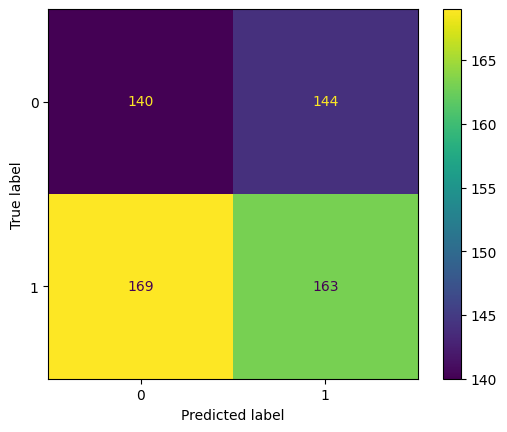

In [ ]:
evaluate(y_pred, y_test)

## Hyperparameters

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
import random

param_dist = {'n_estimators': np.arange(50,1400),
              'max_depth': np.arange(1,100)}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf,
                                 param_distributions = param_dist,
                                 n_iter=8,
                                 cv=6)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=6, estimator=RandomForestClassifier(), n_iter=8,
                   param_distributions={'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),
                                        'n_estimators': array([  50,   51,   52, ..., 1397, 1398, 1399])})

In [ ]:
# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

# Generate predictions with the best model
y_pred = best_rf.predict(X_test)

Best hyperparameters: {'n_estimators': 1062, 'max_depth': 73}


## Generate Output

In [47]:
testDate = y_test.reset_index()
testDate = testDate['Date'].dt.strftime('%Y%m%d')
testDate = pd.DataFrame(testDate)

In [48]:
output = pd.concat([pd.DataFrame(testDate), pd.DataFrame(y_pred, columns = ['Prediction'])], axis=1)

compression_opts = dict(method='zip', archive_name='output.csv')
output.to_csv('output.zip', index=False, compression=compression_opts)
output

,Date,Prediction
0,20220103,0
1,20220104,0
2,20220105,0
3,20220106,0
4,20220107,0
...,...,...
603,20230810,0
604,20230811,0
605,20240802,1
606,20240803,0


# MLP

In [36]:
X_train, y_train, X_test, y_test = split_data(df)

In [37]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [38]:
from sklearn.neural_network import MLPRegressor

#Initializing the MLP Regressor
regressor = MLPRegressor(hidden_layer_sizes=(5), max_iter=200,solver='adam',random_state=1)

#Fitting MLP Regressor to the Training Set
regressor.fit(X_train, y_train)

#Predicting the test set results
y_pred = regressor.predict(X_test)

In [39]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# R_squared and RMSE value
test_set_rsquared = regressor.score(X_test, y_test)
test_set_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print('R_squared value: ', test_set_rsquared)
print('RMSE: ', test_set_rmse)

mae = mean_absolute_error(y_test, y_pred)
print("MAE = ", mae)

R_squared value:  -0.19264859422852054
RMSE:  0.5458974808889785
MAE =  0.503279651932586
